# Food Vision

## Check GPU & Get Helper Functions
Ideally need a Tesla T4 (i.e. compute score higher than 7.0) to see best speed up from mixed precision training.

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-266d6a40-0295-47c3-a446-910f59edca1a)


In [4]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
from helper_functions import *

--2021-08-24 18:53:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-24 18:53:38 (101 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Import data with tensorflow datasets

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [6]:
# list all available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list) # is food101 in this list?

True


In [7]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data as tuple i.e. (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteN4R0EH/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteN4R0EH/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring Food101 data from TensorFlow Datasets

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

### Plot an image from tensorflow datasets


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 43
  Class name (str form): fried_calamari
    


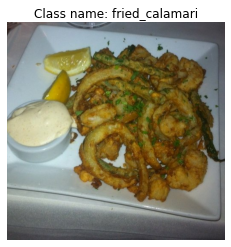

In [11]:
# output info about our training sample
for image, label in train_one_sample:
  img_class = class_names[label.numpy()]
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {img_class}
    """)
  # i.e. labels are not one hot encoded - use loss="sparse_crossentropy"
  plt.figure()
  plt.imshow(image)
  plt.title(f"Class name: {img_class}")
  plt.axis(False)
  plt.show()


## Preprocessing Function

In [12]:
def preprocess_img(image, label, img_shape=224):
    """
    Convert image datatype from 'uint8' > 'float32' and reshapes
    image to [img_shape, img_shape, 3]
    """
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label

## Data Input Pipeline

In [13]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Train Data: {train_data} \nTest Data: {test_data}\n")

Train Data: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)> 
Test Data: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>



# Models 0 & 1 (No Data Aug)

## Feature Extraction Model

In [14]:
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [15]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      verbose=0)
mixed_precision.set_global_policy("mixed_float16")

# #############################################################
# FEATURE EXTRACTION MODEL
# #############################################################
input_shape=(224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model0 = tf.keras.Model(inputs, outputs, name="FeatureExtraction_ThreeEpochs")

model0.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model0.summary()


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


16719872/16705208 [==============================] - 0s 0us/step
Model: "FeatureExtraction_ThreeEpochs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [16]:
history_feat_extr = model0.fit(train_data,
                              epochs=3,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=[model_checkpoint,
                                         create_tensorboard_callback(dir_name="tensorboard_callbacks",
                                             experiment_name="EfficientNetB0_feature_extractor")],
                              verbose=1)

Saving TensorBoard log files to: tensorboard_callbacks/EfficientNetB0_feature_extractor/20210824-190502
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 222s 78ms/step - loss: 1.8232 - accuracy: 0.5555 - val_loss: 1.2283 - val_accuracy: 0.6798
Epoch 2/3
2368/2368 [==============================] - 163s 68ms/step - loss: 1.2946 - accuracy: 0.6648 - val_loss: 1.1211 - val_accuracy: 0.7018
Epoch 3/3
2368/2368 [==============================] - 160s 67ms/step - loss: 1.1436 - accuracy: 0.7011 - val_loss: 1.0826 - val_accuracy: 0.7079


In [17]:
model0.save("drive/MyDrive/tf/models/FoodVision/featureExtractor")

INFO:tensorflow:Assets written to: drive/MyDrive/tf/models/FoodVision/featureExtractor/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tf/models/FoodVision/featureExtractor/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


790/790 [==============================] - 55s 68ms/step - loss: 1.0884 - accuracy: 0.7063


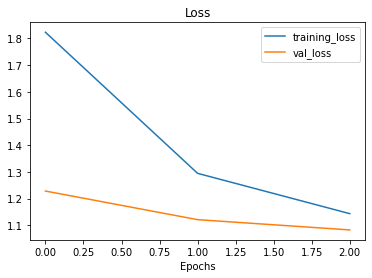

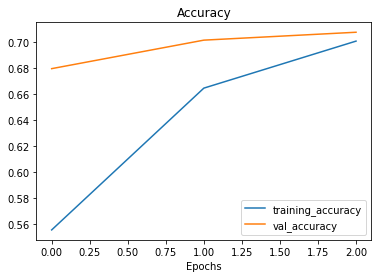

In [18]:
plot_loss_curves(history_feat_extr)
feat_extr_res = model0.evaluate(test_data)

## Fine Tune Feature Extractor (10 Layers, 3 + 3 Epochs)

In [19]:
model1 = tf.keras.models.load_model("drive/MyDrive/tf/models/FoodVision/featureExtractor/")

In [20]:
# confirm model0 loaded properly into model1
loaded_model_res = model1.evaluate(test_data)
print(feat_extr_res[1], loaded_model_res[1], np.isclose(feat_extr_res[1], loaded_model_res[1]))

790/790 [==============================] - 54s 64ms/step - loss: 1.0884 - accuracy: 0.7063
0.7063366174697876 0.7063366174697876 True


In [21]:
model1._name = "Model0_FineTuned_10Layers_SixEpochsTotal"
model1.summary()

Model: "Model0_FineTuned_10Layers_SixEpochsTotal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [22]:
for layer in model1.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 False
global_average_pooling2d True
dense True
softmax_float32 True


In [23]:
model1.layers[1].trainable=True
for layer in model1.layers[1].layers[:-10]:
  layer.trainable = False
for i, layer in enumerate(model1.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [24]:
checkpoint_path = "model_checkpoints/fine_tuned.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      verbose=0)

model1.compile(loss="sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
               metrics=["accuracy"])

fine_tune_epochs = 6 # (3+3)

history_fine_tune = model1.fit(train_data,
                              epochs=fine_tune_epochs,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              initial_epoch=history_feat_extr.epoch[-1],
                              callbacks = [model_checkpoint, create_tensorboard_callback(dir_name="tensorboard_callbacks",
                                             experiment_name="EfficientNetB0_fine_tuned_3")],
                              verbose=2)

Saving TensorBoard log files to: tensorboard_callbacks/EfficientNetB0_fine_tuned_3/20210824-191835
Epoch 3/6


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 - 164s - loss: 0.9474 - accuracy: 0.7493 - val_loss: 0.9941 - val_accuracy: 0.7246
Epoch 4/6
2368/2368 - 157s - loss: 0.8013 - accuracy: 0.7877 - val_loss: 0.9628 - val_accuracy: 0.7362
Epoch 5/6
2368/2368 - 154s - loss: 0.6910 - accuracy: 0.8164 - val_loss: 0.9736 - val_accuracy: 0.7341
Epoch 6/6
2368/2368 - 154s - loss: 0.5968 - accuracy: 0.8415 - val_loss: 0.9779 - val_accuracy: 0.7370


In [25]:
model1.save("drive/MyDrive/tf/models/FoodVision/fineTuned_6epochs")

INFO:tensorflow:Assets written to: drive/MyDrive/tf/models/FoodVision/fineTuned_6epochs/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tf/models/FoodVision/fineTuned_6epochs/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


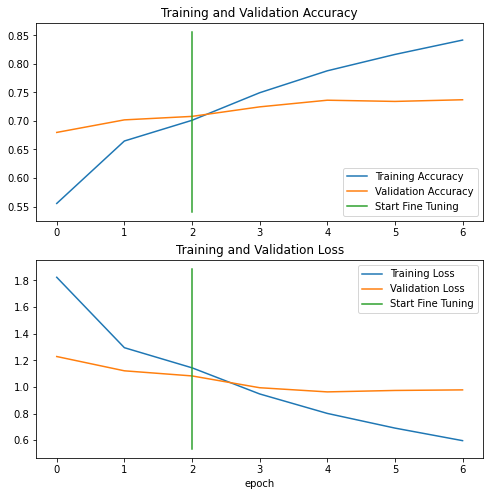

790/790 [==============================] - 55s 68ms/step - loss: 0.9724 - accuracy: 0.7397

Feature Extractor Accuracy: 70.63%
Fine Tuned Accuracy: 73.97%


In [26]:
compare_historys(history_feat_extr, history_fine_tune, 3)
fine_tune_res = model1.evaluate(test_data)
print()
print(f"Feature Extractor Accuracy: {100*feat_extr_res[1]:.2f}%")
print(f"Fine Tuned Accuracy: {100*fine_tune_res[1]:.2f}%")

# Models 2 and 3 (Data Aug)

## Augment dataset

In [27]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [28]:
def augment_img(image, label, img_shape=224):
    """
    Convert image datatype from 'uint8' > 'float32' and reshapes
    image to [img_shape, img_shape, 3]
    """
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label

In [29]:
(train_data_a, test_data_a), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)
data_augmentation = Sequential([
  preprocessing.Resizing(224, 224),
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2)
], name="augmentation_layer")

train_data_a = train_data_a.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)#.map(map_func=data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
train_data_a = train_data_a.shuffle(buffer_size=500).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data_a = test_data_a.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data_a = test_data_a.shuffle(buffer_size=500).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

## Feature Extraction Model (Data Aug)

In [30]:
checkpoint_path = "model_checkpoints/model2.ckpt"
model2_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      verbose=0)
mixed_precision.set_global_policy("mixed_float16")

# #############################################################
# FEATURE EXTRACTION MODEL
# #############################################################
input_shape=(224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
#x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model2 = tf.keras.Model(inputs, outputs, name="FeatureExtraction_ThreeEpochs_DataAug")

model2.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model2.summary()

Model: "FeatureExtraction_ThreeEpochs_DataAug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
augmentation_layer (Sequenti (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________

In [31]:
history_feat_extr_data_aug = model2.fit(train_data_a,
                              epochs=3,
                              steps_per_epoch=len(train_data_a),
                              validation_data=test_data_a,
                              validation_steps=int(0.15*len(test_data_a)),
                              callbacks=[model2_checkpoint,
                                         create_tensorboard_callback(dir_name="tensorboard_callbacks",
                                             experiment_name="EfficientNetB0_feature_extractor_data_aug")],
                              verbose=1)

Saving TensorBoard log files to: tensorboard_callbacks/EfficientNetB0_feature_extractor_data_aug/20210824-193232
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 174s 71ms/step - loss: 2.2034 - accuracy: 0.4682 - val_loss: 1.3656 - val_accuracy: 0.6390
Epoch 2/3
2368/2368 [==============================] - 163s 68ms/step - loss: 1.7021 - accuracy: 0.5687 - val_loss: 1.2515 - val_accuracy: 0.6555
Epoch 3/3
2368/2368 [==============================] - 163s 69ms/step - loss: 1.5807 - accuracy: 0.5953 - val_loss: 1.2062 - val_accuracy: 0.6724


In [32]:
model2.save("drive/MyDrive/tf/models/FoodVision/featureExtractor_dataAug")

INFO:tensorflow:Assets written to: drive/MyDrive/tf/models/FoodVision/featureExtractor_dataAug/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tf/models/FoodVision/featureExtractor_dataAug/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


790/790 [==============================] - 51s 63ms/step - loss: 1.2251 - accuracy: 0.6688


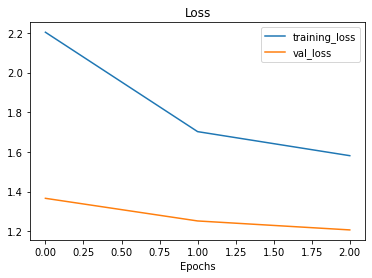

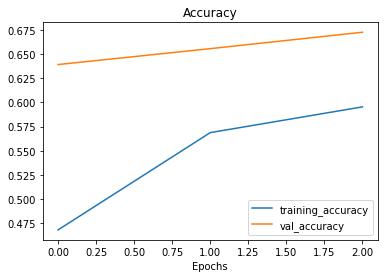

In [33]:
plot_loss_curves(history_feat_extr_data_aug)
feat_extr_res_data_aug = model2.evaluate(test_data_a)

## Fine Tune Model 1 (10 Layers for 3 more epochs, Data Aug)

In [34]:
model3 = tf.keras.models.load_model("drive/MyDrive/tf/models/FoodVision/featureExtractor_dataAug")
model3._name = "Model3_FineTuned_10Layers_SixEpochsTotal_DataAug"

Model: "Model3_FineTuned_10Layers_SixEpochsTotal_DataAug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
augmentation_layer (Sequenti (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
__

In [35]:
model3.layers[2].trainable=True
for layer in model3.layers[2].layers[:-10]:
  layer.trainable = False

In [54]:
model3.summary()

Model: "Model3_FineTuned_10Layers_SixEpochsTotal_DataAug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
augmentation_layer (Sequenti (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 1,022,613
Non-trainable params: 3,156,339


In [36]:
checkpoint_path = "model_checkpoints/fine_tuned_data_aug.ckpt"
model3_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      verbose=0)

model3.compile(loss="sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
               metrics=["accuracy"])

fine_tune_epochs = 6 # (3+3)

history_fine_tune_data_aug = model3.fit(train_data,
                              epochs=fine_tune_epochs,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              initial_epoch=history_feat_extr.epoch[-1],
                              callbacks = [model3_checkpoint, create_tensorboard_callback(dir_name="tensorboard_callbacks",
                                             experiment_name="EfficientNetB0_fine_tuned_data_aug")],
                              verbose=2)

Saving TensorBoard log files to: tensorboard_callbacks/EfficientNetB0_fine_tuned_data_aug/20210824-194306
Epoch 3/6


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 - 168s - loss: 1.3811 - accuracy: 0.6415 - val_loss: 1.0627 - val_accuracy: 0.7142
Epoch 4/6
2368/2368 - 163s - loss: 1.2510 - accuracy: 0.6735 - val_loss: 1.0461 - val_accuracy: 0.7209
Epoch 5/6
2368/2368 - 161s - loss: 1.1687 - accuracy: 0.6899 - val_loss: 1.0359 - val_accuracy: 0.7214
Epoch 6/6
2368/2368 - 164s - loss: 1.1035 - accuracy: 0.7055 - val_loss: 1.0326 - val_accuracy: 0.7169


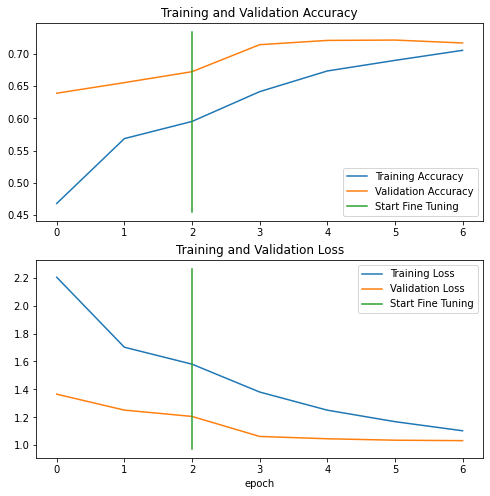

790/790 [==============================] - 53s 65ms/step - loss: 1.0180 - accuracy: 0.7217

Fine Tuned (w/ Data Augmentation) Accuracy: 72.17%


In [38]:
compare_historys(history_feat_extr_data_aug, history_fine_tune_data_aug, 3)
fine_tune_data_aug_res = model3.evaluate(test_data)
print()
print(f"Fine Tuned (w/ Data Augmentation) Accuracy: {100*fine_tune_data_aug_res[1]:.2f}%")

In [40]:
model3.save("drive/MyDrive/tf/models/FoodVision/fineTuned_dataAug")

INFO:tensorflow:Assets written to: drive/MyDrive/tf/models/FoodVision/fineTuned_dataAug/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tf/models/FoodVision/fineTuned_dataAug/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Fine Tune Model 2 (All Layers for 3 More epochs, Augmented Data)

In [39]:
model4 = tf.keras.models.load_model("drive/MyDrive/tf/models/FoodVision/featureExtractor_dataAug")
model4._name = "Model4_FineTuned_AllLayers_SixEpochsTotal_DataAug"

In [42]:
model4.layers[2].trainable=True

In [53]:
model4.summary()

Model: "Model4_FineTuned_AllLayers_SixEpochsTotal_DataAug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
augmentation_layer (Sequenti (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
__

In [45]:
checkpoint_path = "model_checkpoints/fine_tuned_AllLayers_data_aug.ckpt"
model4_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      verbose=0)

model4.compile(loss="sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
               metrics=["accuracy"])

fine_tune_epochs = 6 # (3+3)

history_fine_tune_AllLayers_data_aug = model4.fit(train_data,
                              epochs=fine_tune_epochs,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              initial_epoch=history_feat_extr_data_aug.epoch[-1],
                              callbacks = [model4_checkpoint, create_tensorboard_callback(dir_name="tensorboard_callbacks",
                                             experiment_name="EfficientNetB0_fine_tuned_AllLayers_data_aug")],
                              verbose=2)

Saving TensorBoard log files to: tensorboard_callbacks/EfficientNetB0_fine_tuned_AllLayers_data_aug/20210824-200402
Epoch 3/6


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 - 348s - loss: 0.9533 - accuracy: 0.7442 - val_loss: 0.8280 - val_accuracy: 0.7741
Epoch 4/6
2368/2368 - 334s - loss: 0.7802 - accuracy: 0.7858 - val_loss: 0.8565 - val_accuracy: 0.7624
Epoch 5/6
2368/2368 - 329s - loss: 0.6439 - accuracy: 0.8190 - val_loss: 0.8650 - val_accuracy: 0.7630
Epoch 6/6
2368/2368 - 329s - loss: 0.5397 - accuracy: 0.8453 - val_loss: 0.7538 - val_accuracy: 0.7963


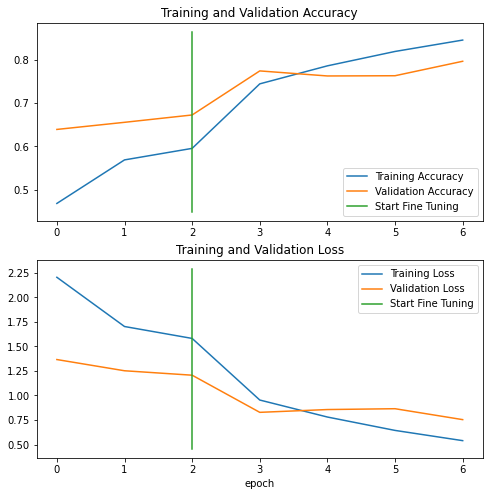

790/790 [==============================] - 58s 72ms/step - loss: 0.7824 - accuracy: 0.7899

Fine Tuned (All Layers) Accuracy: 78.99%


In [46]:
compare_historys(history_feat_extr_data_aug, history_fine_tune_AllLayers_data_aug, 3)
fine_tune_data_AllLayers_aug_res = model4.evaluate(test_data)
print()
print(f"Fine Tuned (All Layers) Accuracy: {100*fine_tune_data_AllLayers_aug_res[1]:.2f}%")

In [47]:
model4.save("drive/MyDrive/tf/models/FoodVision/fineTuned_AllLayers")

INFO:tensorflow:Assets written to: drive/MyDrive/tf/models/FoodVision/fineTuned_AllLayers/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tf/models/FoodVision/fineTuned_AllLayers/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


This has beaten the 77.4% accuracy benchmark set by the [DeepFood Paper](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment). Now let's see if we can improve our model further by using an adaptive learning rate callback (while also adding an early stopping callback).

# Fine Tune Model 3 (All Layers for 3 more Epochs, Augmented Data, Adaptive LR )

In [50]:
# model as prior this time with an adaptive learning rate callback
model5 = tf.keras.models.load_model("drive/MyDrive/tf/models/FoodVision/featureExtractor_dataAug")
model5._name = "Model5_FineTuned_AllLayers_SixEpochsTotal_DataAug_DynLR"

In [52]:
model5.layers[2].trainable=True
model5.summary()

checkpoint_path = "model_checkpoints/fine_tuned_DynLR.ckpt"
model5_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      verbose=0)

dynLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

model5.compile(loss="sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
               metrics=["accuracy"])

fine_tune_epochs = 6 # (3+3)

history_fine_tune_DynLR = model5.fit(train_data,
                              epochs=fine_tune_epochs,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              initial_epoch=history_feat_extr_data_aug.epoch[-1],
                              callbacks = [model4_checkpoint,
                                           create_tensorboard_callback(dir_name="tensorboard_callbacks",
                                             experiment_name="EfficientNetB0_fine_tuned_DynLR"),
                                           dynLR,
                                           early_stopping],
                              verbose=2)

Model: "Model5_FineTuned_AllLayers_SixEpochsTotal_DataAug_DynLR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
augmentation_layer (Sequenti (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 - 337s - loss: 0.9120 - accuracy: 0.7540 - val_loss: 0.8187 - val_accuracy: 0.7738
Epoch 4/6
2368/2368 - 328s - loss: 0.7498 - accuracy: 0.7933 - val_loss: 0.8022 - val_accuracy: 0.7773
Epoch 5/6
2368/2368 - 324s - loss: 0.6264 - accuracy: 0.8233 - val_loss: 0.8745 - val_accuracy: 0.7677
Epoch 6/6
2368/2368 - 327s - loss: 0.5142 - accuracy: 0.8523 - val_loss: 0.7931 - val_accuracy: 0.7871


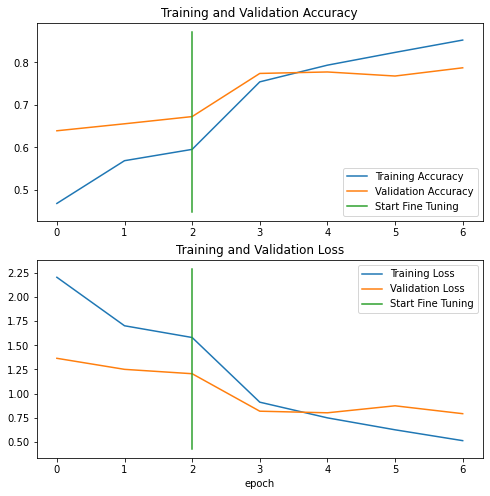

790/790 [==============================] - 58s 71ms/step - loss: 0.8345 - accuracy: 0.7768

Fine Tuned (w/ Dynamic LR) Accuracy: 77.68%


In [55]:
compare_historys(history_feat_extr_data_aug, history_fine_tune_DynLR, 3)
fine_tune_data_DynLR = model5.evaluate(test_data)
print()
print(f"Fine Tuned (w/ Dynamic LR) Accuracy: {100*fine_tune_data_DynLR[1]:.2f}%")

# Upload experiments to Tensorboard

In [ ]:
!tensorboard dev upload --logdir ./tensorboard_callbacks \
  --name "Fine-tuning EfficientNetB0 on Food101 Dataset" \
  --description "Series of experiments  building a fine-tuned feature extractor  to beat the DeepFood Model" \
  --one_shot

Link to [Tensorboard experiments](https://tensorboard.dev/experiment/czQqJh3wSASgF94WxzzATQ/)